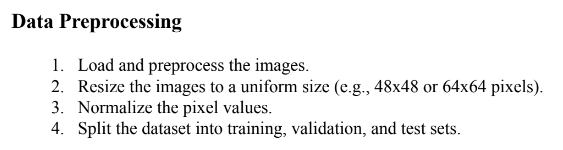

In [6]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("apollo2506/facial-recognition-dataset")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/apollo2506/facial-recognition-dataset/versions/3


In [7]:
import os

folder_path = "/root/.cache/kagglehub/datasets/apollo2506/facial-recognition-dataset/versions/3/"
training_folder = os.path.join(folder_path, 'Training/Training')
for subfolder in os.listdir(training_folder):
    print(f"Subfolder found: {subfolder}")


Subfolder found: Neutral
Subfolder found: Fear
Subfolder found: Sad
Subfolder found: Suprise
Subfolder found: Happy
Subfolder found: Angry


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np
import shutil

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [10]:

# Function to load and preprocess images
def load_images_from_folder(folder, image_size=(64, 64)):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                img = cv2.imread(os.path.join(subfolder_path, filename))
                if img is not None:
                    img = cv2.resize(img, image_size)  # Resize to uniform size
                    img = img / 255.0  # Normalize pixel values
                    images.append(img)
                    labels.append(subfolder)  # Labels are the folder names (Angry, Happy, etc.)
    return np.array(images), np.array(labels)


In [11]:

# Load the images and labels from the dataset
folder_path = "/root/.cache/kagglehub/datasets/apollo2506/facial-recognition-dataset/versions/3/Training/Training"
images, labels = load_images_from_folder(folder_path)


In [12]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels, num_classes=6)  # 6 classes

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.7, random_state=42)


In [14]:
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (19791, 64, 64, 3), (19791, 6)
Validation set shape: (2544, 64, 64, 3), (2544, 6)
Test set shape: (5938, 64, 64, 3), (5938, 6)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50


In [16]:
IMAGE_SIZE = (64, 64, 3)

base_model_vgg16 = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
base_model_vgg16.trainable = False
inputs = Input(shape=IMAGE_SIZE)
x = base_model_vgg16(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)
model_vgg16 = Model(inputs, outputs)
model_vgg16.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_vgg16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
base_model_resnet50 = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
base_model_resnet50.trainable = False
x_resnet = base_model_resnet50(inputs, training=False)
x_resnet = GlobalAveragePooling2D()(x_resnet)
x_resnet = Dense(256, activation='relu')(x_resnet)
outputs_resnet = Dense(6, activation='softmax')(x_resnet)
model_resnet50 = Model(inputs, outputs_resnet)
model_resnet50.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_resnet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_vgg16 = model_vgg16.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.3316 - loss: 1.6334 - val_accuracy: 0.3915 - val_loss: 1.5221
Epoch 2/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4146 - loss: 1.4872 - val_accuracy: 0.4167 - val_loss: 1.4850
Epoch 3/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4247 - loss: 1.4517 - val_accuracy: 0.4403 - val_loss: 1.4472
Epoch 4/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4424 - loss: 1.4161 - val_accuracy: 0.4414 - val_loss: 1.4325
Epoch 5/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4539 - loss: 1.3886 - val_accuracy: 0.4465 - val_loss: 1.4191
Epoch 6/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4726 - loss: 1.3558 - val_accuracy: 0.4591 - val_loss: 1.4034
Epoch 7/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4882 - loss: 1.3238 - val_accuracy: 0.4414 - val_loss: 1.4253
Epoch 8/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5014 - loss: 1.2985 - 

In [19]:
history_resnet50 = model_resnet50.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.2448 - loss: 1.7666 - val_accuracy: 0.2740 - val_loss: 1.7341
Epoch 2/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.2804 - loss: 1.7143 - val_accuracy: 0.2980 - val_loss: 1.6981
Epoch 3/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3039 - loss: 1.6859 - val_accuracy: 0.2854 - val_loss: 1.6869
Epoch 4/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3131 - loss: 1.6668 - val_accuracy: 0.3208 - val_loss: 1.6674
Epoch 5/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3211 - loss: 1.6562 - val_accuracy: 0.3180 - val_loss: 1.6609


In [20]:
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(X_test, y_test)
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(X_test, y_test)
print(f"VGG16 Test loss: {test_loss_vgg16}, Test accuracy: {test_acc_vgg16}")
print(f"ResNet50 Test loss: {test_loss_resnet50}, Test accuracy: {test_acc_resnet50}")


186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4504 - loss: 1.4157
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2866 - loss: 1.7314
VGG16 Test loss: 1.417809247970581, Test accuracy: 0.45335128903388977
ResNet50 Test loss: 1.732544183731079, Test accuracy: 0.28292354941368103


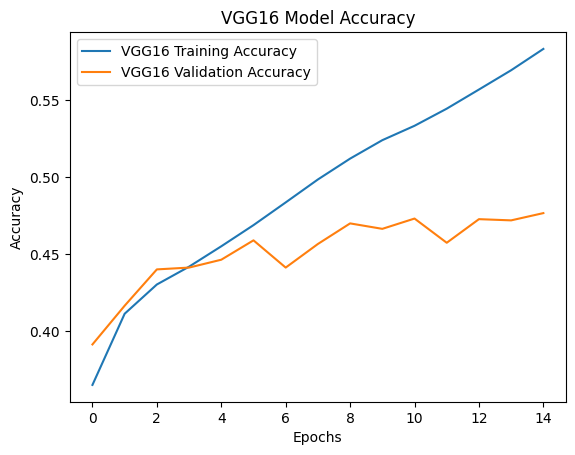

In [21]:
import matplotlib.pyplot as plt

plt.plot(history_vgg16.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


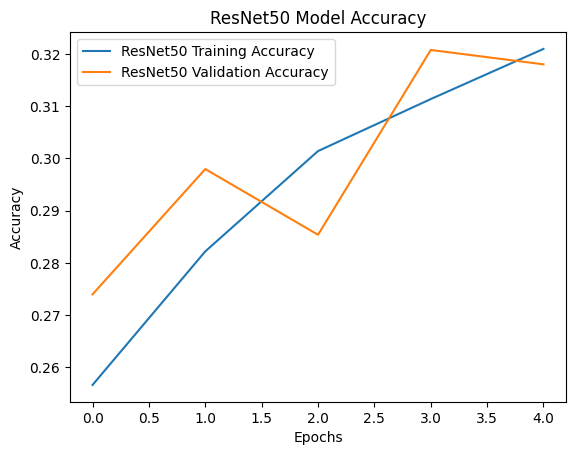

In [22]:
plt.plot(history_resnet50.history['accuracy'], label='ResNet50 Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

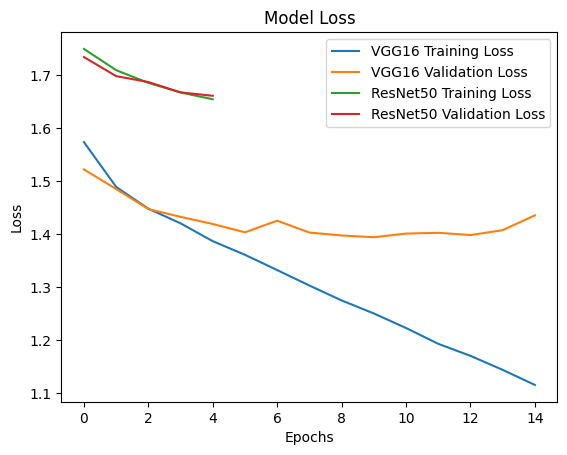

In [23]:
plt.plot(history_vgg16.history['loss'],label='VGG16 Training Loss')
plt.plot(history_vgg16.history['val_loss'],label='VGG16 Validation Loss')
plt.plot(history_resnet50.history['loss'], label='ResNet50 Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='ResNet50 Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()